# Analisis zonaprop

# Agenda:
* General
* Data cleaning
* Análisis exploratorio

# General

In [1]:
# Importamos librerías de análisis de datos
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import partial

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Creamos el dataframe y le asignamos como id del dataframe, el id de cada row del csv.
df = pd.read_csv('train.csv', index_col='id')

In [9]:
#chequeo info general.
print("shape:", df.shape, "\n")
print("columns:", df.columns, "\n")
print(f"provincias: {df.provincia.unique()} \n")
print(f"tipodepropiedad: {df.tipodepropiedad.unique()}")

shape: (240000, 20)

columns: Index(['tipodepropiedad', 'direccion', 'ciudad', 'provincia', 'antiguedad',
       'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'idzona', 'lat', 'lng', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio'],
      dtype='object') 

provincias: ['distrito federal' 'jalisco' 'edo. de méxico' 'oaxaca' 'quintana roo'
 'colima' 'san luis potosí' 'nuevo león' 'querétaro' 'tamaulipas' 'puebla'
 'yucatán' 'morelos' 'guerrero' 'tabasco' 'guanajuato' 'hidalgo'
 'veracruz' 'chihuahua' 'aguascalientes' 'sonora' 'michoacán'
 'baja california norte' 'baja california sur' 'coahuila' 'durango'
 'sinaloa' 'chiapas' 'nayarit' 'tlaxcala' 'campeche' 'zacatecas' nan] 

tipodepropiedad: ['apartamento' 'casa en condominio' 'casa' 'terreno' 'terreno comercial'
 'local comercial' 'quinta vacacional' 'oficina comercial' 'edificio'
 'casa uso de suelo' 'local en centro comercial' 'bodega c

# Data cleaning

In [4]:
#elimino features que no usaremos en el analisis del data set
del df['titulo']
del df['descripcion']

In [142]:
#datos faltantes
nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
nulls

,nulls,porcentaje
precio,0,0.00
escuelascercanas,0,0.00
piscina,0,0.00
usosmultiples,0,0.00
gimnasio,0,0.00
fecha,0,0.00
centroscomercialescercanos,0,0.00
tipodepropiedad,46,0.02
provincia,155,0.06
ciudad,372,0.16


In [5]:
#normalizo tipodepropiedad, direccion, ciudad y provincia a lowercase
def convert_to_lower(df, feature):
    df[feature] = df[feature].str.lower()

convert_to_lower(df, 'tipodepropiedad')
convert_to_lower(df, 'direccion')
convert_to_lower(df, 'ciudad')
convert_to_lower(df, 'provincia')

In [6]:
#valido que habitaciones, garages, banos sean valores enteros

def is_integer(number):
    frac, _ = math.modf(number)
    return frac == 0

def drop_nan_from_arr(arr):
    return [x for x in arr if ~np.isnan(x)]

def apply_all(arr, function):
    return all([function(x) for x in arr])

unique_habitaciones = df.habitaciones.unique()
unique_habitaciones = drop_nan_from_arr(unique_habitaciones)
print("unique_habitaciones:", apply_all(unique_habitaciones, is_integer))

unique_garages = df.garages.unique()
unique_garages = drop_nan_from_arr(unique_garages)
print("unique_garages:", apply_all(unique_garages, is_integer))

unique_banos = df.banos.unique()
unique_banos = drop_nan_from_arr(unique_banos)
print("unique_banos:", apply_all(unique_banos, is_integer))

unique_habitaciones: True
unique_garages: True
unique_banos: True


In [7]:
#'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas','centroscomercialescercanos'
# parecen ser booleanos por ser siempre 0 Y 1 y por la naturaleza del feature.
# Analizo si es acertada la suposicion, de serlo, los convierto en Boolean, van a ocupar menos espacio.

def is_boolean(x):
    return x == 0 or x == 1

def int_to_bool(x):
    return x != 0

unique_gimnasio = df.gimnasio.unique()
unique_gimnasio = drop_nan_from_arr(unique_gimnasio)
print("unique_gimnasio is_boolean:", apply_all(unique_gimnasio, is_boolean))
df.gimnasio = df.gimnasio == True

unique_usosmultiples = df.usosmultiples.unique()
unique_usosmultiples = drop_nan_from_arr(unique_usosmultiples)
print("unique_usosmultiples is_boolean:", apply_all(unique_usosmultiples, is_boolean))
df.usosmultiples = df.usosmultiples == True

unique_piscina = df.piscina.unique()
unique_piscina = drop_nan_from_arr(unique_piscina)
print("unique_piscina is_boolean:", apply_all(unique_piscina, is_boolean))
df.piscina = df.piscina == True

unique_escuelascercanas = df.escuelascercanas.unique()
unique_escuelascercanas = drop_nan_from_arr(unique_escuelascercanas)
print("unique_escuelascercanas is_boolean:", apply_all(unique_escuelascercanas, is_boolean))
df.escuelascercanas = df.escuelascercanas == True

unique_centroscomercialescercanos = df.centroscomercialescercanos.unique()
unique_centroscomercialescercanos = drop_nan_from_arr(unique_centroscomercialescercanos)
print("unique_centroscomercialescercanos is_boolean:", apply_all(unique_centroscomercialescercanos, is_boolean))
df.centroscomercialescercanos = df.centroscomercialescercanos == True

unique_gimnasio is_boolean: True
unique_usosmultiples is_boolean: True
unique_piscina is_boolean: True
unique_escuelascercanas is_boolean: True
unique_centroscomercialescercanos is_boolean: True


In [137]:
# VALIDO QUE TODAS LAS FECHAS DE LA FEATURE 'fecha' ESTEN ENTRE 2012 Y 2016

def date_between(date1, date2, date_to_compare):
    return date1 < date_to_compare and date_to_compare < date2

#aplicacion parcial de 'date_between(date1, date2, date_to_compare)'
partial_date_between = partial(date_between,'2012-00-00 00:00:00', '2017-00-00 00:00:00')
apply_all(df.fecha, partial_date_between)

True

# Analisis Exploratorio

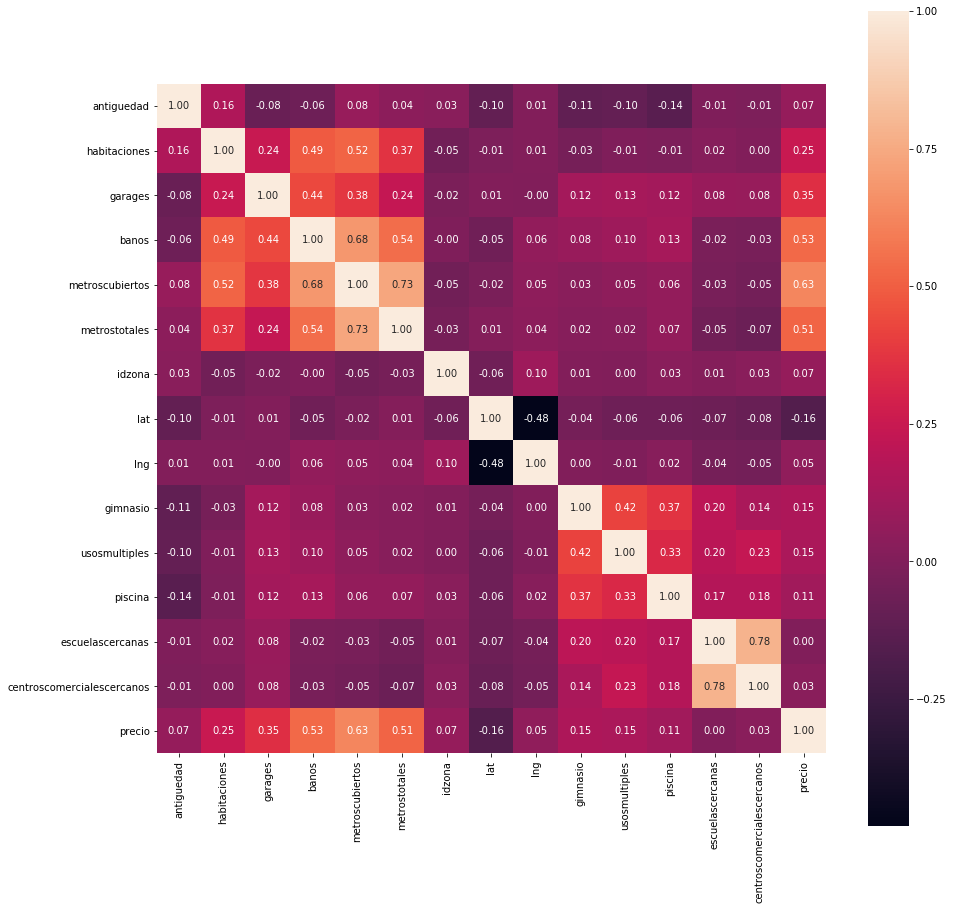

In [167]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f');

In [ ]:
# Del grafico se desprende que las siguientes grupos de features estan correlacionadas.
# A) habitaciones, garages, banos, metroscubiertos, metrostotales entre si.
# B) Las vars de (A) con precio
# C) centroscomercialescercanos con escuelascercanas
# D) gimnasio, usosmultiples, piscina

# Analizo (C)
# Hay una alta probabilidad de que al exisitir centros comerciales cercanos tambien existiran
# escuelas cercanas y viceversa. Al ser features booleanas un scatter plot no nos dara info relevante.

# Analizo (D)
# Hay una probabilidad medianamente elevada de que la propiedad disponga 
# de gimnasio, usosmultiples y piscina a la vez. Al ser features booleanas un scatter plot no nos dara info relevante.

In [33]:
df_corr = df.filter(['habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales'], axis=1)

In [35]:
#funciones que me permiten graficar el data set con el fin de detectar outliers visualmente

def get_column(A, j): 
    return A.iloc[:,j]

def scatter_matrix(df_corr, figsize):
    
    df_corr = df_corr.copy()
    df_corr = df_corr.dropna()
    df_corr = df_corr.sample(1000, random_state=1)

    _, num_columns = df_corr.shape
    fig, ax = plt.subplots(num_columns, num_columns, figsize = figsize) 

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(df_corr, j), get_column(df_corr, i), alpha=0.15)

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5), 
                                    xycoords='axes fraction', 
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False) 
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them 
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim()) 
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()
    
def scatter_list(df_corr, fixed_column, figsize):
    _, num_columns = df_corr.shape
    fig, ax = plt.subplots(1, num_columns, figsize = figsize) 

    for i in range(num_columns):
        
        i_column = get_column(df_corr, i)
        aux = pd.DataFrame()
        aux['A'] = i_column
        aux['B'] = fixed_column
        aux.dropna()
        aux = aux.sample(1000, random_state=1)

        ax[i].scatter(aux['A'], aux['B'], alpha=0.15)
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)

    plt.show()
    
def boxplot_list(df):
    
    df = df.copy().dropna()

    _, num_columns = df.shape
    fig, ax = plt.subplots(1, num_columns, figsize = (4 * num_columns, 4)) 
    red_square = dict(markerfacecolor='r', marker='s')

    
    for i in range(num_columns):        
        i_column = get_column(df, i)
        i_column = i_column.sample(1000, random_state=1)

        ax[i].boxplot(x=i_column, vert=False, flierprops=red_square)
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)

    plt.show()

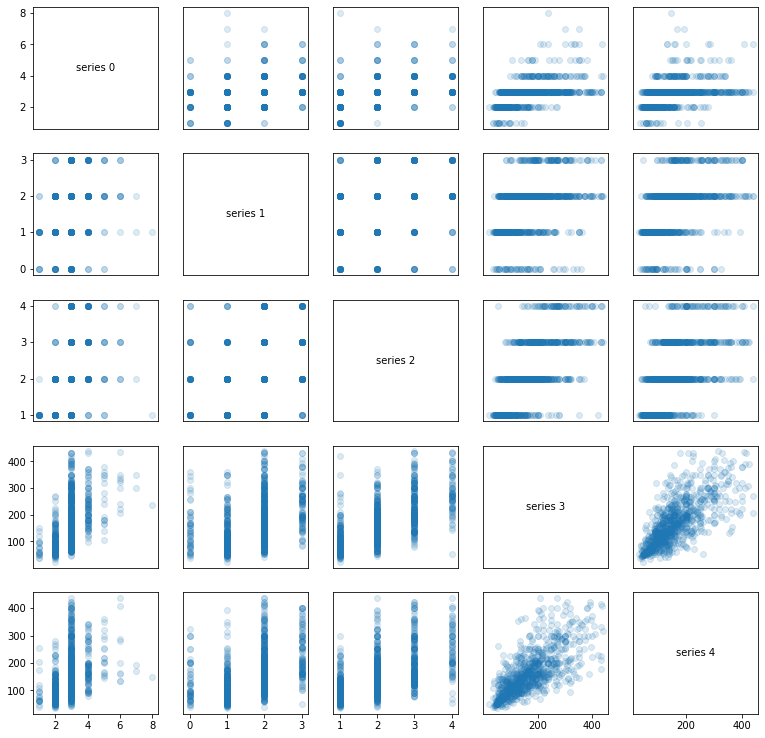

In [36]:
# Analizo (A) -> habitaciones, garages, banos, metroscubiertos, metrostotales entre si.
scatter_matrix(df_corr, figsize=(13,13))

In [11]:
# Analizo(A)

################

# 'habitaciones'

# con respecto a 'garages': 
# propiedades de 2 a 5 habitaciones tienen todo el espectro de garages.
# no hay propiedades de 5 a 8 habitaciones que no tengan garage.

# con respecto a 'banos'
# propiedades de 2 a 5 habitaciones tienen todo el espectro de banos.

# con respecto a 'metrostotales'
# propiedades de 4 a 5 piezas tienen gran variedad con respecto a metros cubiertos
# se visualiza una tendencia a mayor numero de habitaciones mayor metros cubiertos

# con respecto a 'metrostotales'
# propiedades de 4 a 5 piezas tienen gran variedad con respecto a metros totales
# se visualiza una tendencia a mayor numero de habitaciones mayor metros totales

################

# 'garages'

# con respecto a 'banos'
# se puede encontrar propiedades con 0 a 3 garages que tambien tienen de 1 a 4 banos

# con respecto a 'metrostotales' 
# parece que hay una leve tendencia donde a propiedad con mayor metros totales, mayor cantidad de garages.

# con respecto a 'metroscubiertos' 
# parece que hay una leve tendencia donde a propiedad con mayor metros cubiertos, mayor cantidad de garages.

################

# 'banos'
# con respecto a 'metrostotales' 
# parece que hay una leve tendencia donde a propiedad con mayor metros totales, mayor cantidad de banos.

# con respecto a 'metroscubiertos'
# parece que hay una leve tendencia donde a propiedad con mayor metros cubiertos, mayor cantidad de banos.

################

# 'metroscubiertos' con respecto a 'metrostotales'
# hay una tendencia fuerte donde a propiedad con mayor metros totales, mayor cantidad de metros cubiertos.


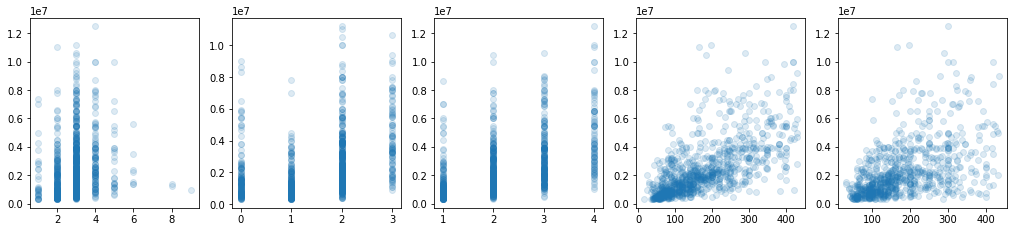

In [37]:
# Analizo (B) -> Las vars de (A) con precio
_, num_columns = df_corr.shape
fixed_column = df.filter(['precio'], axis=1)
scatter_list(df_corr, fixed_column, figsize=(3.5 * num_columns, 3.5))

In [ ]:
# precio

# con respecto a 'habitaciones':
# la mayour cantidad de publicaciones son de 2 a 4 habitaciones.
# hay pocas publicaciones de > 6 habitaciones y no son precios mas elevados que las publ. con habitaciones de 2 a 4.

# con respecto a 'garages': 
# pareciera poder encontrarse publ. con garages de 0 a 2 con precio similar.
# se encuentras solo algunos precios elevados para publ. con garages de 2 a 3

# con respecto a 'banos': 
# pareciera poder encontrarse publ. con banos de 1 a 4 con precio similar.
# pareciera que no hay muchos precios elevados con 1 baño.

# con respecto a 'metroscubiertos' y 'metrostotales': 
# se pueda observar la tendencia de que a mayor precio tenemos mas 'metroscubiertos' y 'metrostotales'

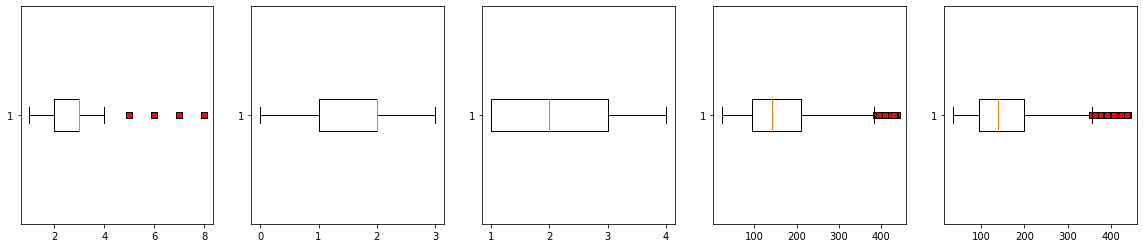

In [38]:
# hago graficos boxplot de sus features con el objetivo de ver los outliers.

boxplot_list(df_corr)

In [56]:
threshold = 3
z = np.abs(stats.zscore(df_corr.dropna()))
outliers = np.where(z > threshold)
#outliers[0] corresponde al nro de row
#outliers[1] corresponde al nro de col
outliers

,0,1,2,3,4,5,6,7,8,9,...,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562
0,56,146,154,170,193,315,362,365,517,545,...,139019,139087,139091,139091,139128,139159,139169,139182,139329,139365
1,4,4,4,0,0,4,3,4,0,0,...,3,4,3,4,4,3,0,4,3,0


### Punto 1

In [ ]:
#ver que provincia/ciudad historicamente tiene las casas mas caras y cual las mas baratas
df1 = df.copy()

In [108]:
#agrupo por provincia, hago sumatoria de los precios y ordeno de mayor a menor
df1.groupby(['provincia']).precio.sum().sort_values(ascending=False)

provincia
Distrito Federal        204101541990.00
Edo. de México          114937877614.00
Jalisco                  50285076179.00
Nuevo León               41646918301.00
Querétaro                36424121914.00
Puebla                   23951664353.00
Morelos                  16802375724.00
San luis Potosí          16221829633.00
Yucatán                  16141565288.00
Quintana Roo             11428510747.00
Veracruz                 10888961462.00
Chihuahua                 8007395512.00
Guerrero                  6825530692.00
Coahuila                  5562103634.00
Guanajuato                5339503977.00
Sonora                    4433342980.00
Tamaulipas                3661003051.00
Michoacán                 3653382570.00
Hidalgo                   3291292899.00
Sinaloa                   2952036390.00
Durango                   2753634936.00
Aguascalientes            2589511913.00
Baja California Norte     2471162435.00
Tabasco                   2286677345.00
Chiapas                   2166

In [ ]:
#agrupo por ciudad, hago sumatoria de los precios y ordeno de mayor a menor
df1.groupby(['ciudad']).precio.sum().sort_values(ascending=False)

In [18]:
#agrupo por provincia y ciudad, hago sumatoria de los precios y ordeno de mayor a menor
df1 = df.copy()
df1 = pd.DataFrame(df1.groupby(['provincia', 'ciudad']).precio.sum())

#
# dentro de cada grupacion por provincia y ciudad no se como ordenar de mayor a menor por precio
# >> df1.groupby(['provincia', 'ciudad']).apply(lambda _df: _df.sort_values(by='precio'))

precio
provincia             ciudad                                 
Aguascalientes        Aguascalientes            2243174932.00
                      Asientos                     9774348.00
                      Calvillo                     4959000.00
                      Cosío                        2660000.00
                      El Llano                     4000000.00
                      Jesús María                303752411.00
                      Pabellón de Arteaga          4492222.00
                      Rincón de Romos              9375000.00
                      San Francisco de los Romo    4774000.00
                      Tepezalá                     2550000.00
Baja California Norte Ensenada                    91791746.00
                      Mexicali                   252931142.00
                      Playas de Rosarito          31755000.00
                      Tecate                      11546000.00
                      Tijuana                   2083138547.00
Baja California Sur   Comondú                      4618760.00
                      La Paz                    1265172784.00
                      Loreto                       4030000.00
                      Los Cabos                  791048253.00
                      Mulegé                       3100000.00
Campeche              Calkiní                      6400000.00
                      Campeche                   173363225.00
                      Carmen                     220702672.00
                      Champotón                   10823000.00
                      Escárcega                     395000.00
                      Hopelchén                     587000.00
                      Palizada                      880490.00
Chiapas               Bella Vista                   654000.00
                      Berriozábal                 44993375.00
                      Chiapa de Corzo             14282000.00
...                                                       ...
Yucatán               Suma                         4800000.00
                      Tahmek                       1200000.00
                      Teabo                        3500000.00
                      Tekax                        7380000.00
                      Telchac Pueblo              24895000.00
                      Telchac Puerto             171008400.00
                      Temax                        1500000.00
                      Temozón                     55255298.00
                      Timucuy                       830000.00
                      Tinum                        1980000.00
                      Tizimín                     17515000.00
                      Tzucacab                     7800000.00
                      Uayma                         600000.00
                      Ucú                          8500000.00
                      Umán                        20486000.00
                      Valladolid                  24776395.00
                      Yaxcabá                      2500000.00
                      Yaxkukul                     2250000.00
                      Yobaín                       5050000.00
Zacatecas             Calera                       2299750.00
                      Fresnillo                    1100000.00
                      Guadalupe                   46733543.00
                      Jerez                        5199000.00
                      Morelos                      2850000.00
                      Río Grande                   1150000.00
                      Sombrerete                   2700000.00
                      Tepechitlán                  1500000.00
                      Villa de Cos                 1050000.00
                      Villanueva                    975000.00
                      Zacatecas                   71095000.00

[904 rows x 1 columns]

### Punto 2

In [3]:
#ver cual provincia tiene mas desvio estandar en sus precios, (idem para ciudades) 
df2 = df.copy()

In [16]:
df2 = df.copy()
df2 = df2.groupby(['provincia']).precio.agg(['std','mean']).sort_values(by='mean')
df2['std > 25%'] = df2['std'] > (df2['mean'] * 0.25)
df2

,std,mean,std > 25%
provincia,,,
Baja California Norte,678467.98,767441.75,True
Tlaxcala,1087415.56,1080993.34,True
Durango,919869.33,1210388.98,True
Baja California Sur,1003929.42,1216452.82,True
Hidalgo,1159939.77,1305550.54,True
Nayarit,1402039.15,1426790.82,True
Zacatecas,1791470.94,1453747.80,True
Aguascalientes,1170392.69,1477188.77,True
Michoacán,1315847.58,1478503.67,True


In [29]:
df2 = df.copy()
df2 = df2.groupby(['provincia','ciudad']).precio.agg(['std','mean'])#como parametrizo cuando paso asi las funciones ??
df2['std > 25%'] = df2['std'] > (df2['mean'] * 0.25)
df2['std'].head()
#
# > std NaN ??????
# > para los casos que da NaN se da que tiene 1 solo elemento o tiene > 1 pero el valor es el mismo entonces no tiene desviacion
#

provincia       ciudad        
Aguascalientes  Aguascalientes   1213727.34
                Asientos         1102986.01
                Calvillo         1485946.50
                Cosío             179257.73
                El Llano          808290.38
Name: std, dtype: float64

### Punto 3

In [55]:
# 3)
# basado en el punto anterior, ver si dentro de esa dispersion en la ciudad o provincia, 
# las casas de mas alto valor se encuentran agrupadas geograficamente dentro de esa ciudad/provincia

In [26]:
#para definir que es una "casa de alto valor" considero que dentro del rango de valor [min, max] de casas de una ciudad
#se define una "casa de alto valor" la que este entre max o (max * 0.90)
df3 = df.copy()
df3.groupby(['provincia','ciudad']).apply(lambda _df: _df.nlargest(((_df.precio.count()*0.1)).astype('int64'),'precio'))

# el lambda hace lo siguiente por cada agrupacion resultante del groupby:
# (_df.precio.count()*0.1) encuentro el 10% del total de cada agrupacion
# ((_df.precio.count()*0.1)).astype('int64') redondeo el nro a un entero
# _df.nlargest(...,'precio') por cada agrupacion obtengo el 10% de los items de mayor precio
#
# TODO: hacer grafico de puntos usan latitud y longitud y pintando estos elementos de otro color
#       para ver si se encuentran agrupados

titulo  \
provincia      ciudad         id                                                          
Aguascalientes Aguascalientes 154112                     aviso prueba 1 aviso prueba 1    
                              64714    edificio en venta en fraccionamiento santa elena   
                              294891        hermosa casa en el centro de aguascalientes   
                              293257                 hermoso departamento en santa fe!!   
                              204460  oficina comercial en venta en bosques del prad...   
                              19522   casa en venta - la herradura - frente a terzet...   
                              226800                    casa en venta lomas de santa fe   
                              1741    sierra vertientes: hermoso departamento para e...   
                              285045  eden los sabinos esquina mas frente que fondo,...   
                              149995  casa muy bonita en el fraccionamiento campestr...   
                              107182  vendo departamento en av. santa fe , estilo y ...   
                              207326  eden los sabinos, con arboles milenarios en ca...   
                              142939  super moderna residencia en coto privado en la...   
                              111222  residencia en una de las zonas mas exclusivas ...   
                              99381   vendo casa en campestre 4ta sección aguascalie...   
                              294784            vende casa en esquina en club campestre   
                              269642                    venta de casa en aguascalientes   
                              85158                        casa en venta en los bosques   
                              274127  amplia casa en venta en la zona más cotizada d...   
                              53017   excelente oportunidad de casa en rinconada bos...   
                              77529                     venta de casa en aguascalientes   
                              235896             maravillosa residencia en el campestre   
                              167995         venta de local comercial en aguascalientes   
                              190443       casa en venta rancho santa imelda rcv 234861   
                              121369  hermosa residencia de lujo en la playa de san ...   
                              31009        excelente oportunidad  casa en las américas    
                              209820            casa en la mejor zona de aguascalientes   
                              235415                    venta de casa en aguascalientes   
                              216235                      departamento de lujo en venta   
                              136987                 hermosísima residencia en un nivel   
...                                                                                 ...   
Yucatán        Progreso       68458                 departamento en la playa, chicxulub   
                              267565  residencia en primera fila de la costa yucatec...   
                              197852  preventa de departamento marola en chicxulub, ...   
                              107585         departamento en venta en progreso, yucatán   
                              66442               se vende  casa frente a la playa. gcl   
                              117544       de oportunidad casa en chicxulub en la playa   
                              153171                                      casa de playa   
                              192666  playa clave  en venta en san bruno, progreso ,...   
                              125056                        acqua departamento *tipo a*   
                              273495  hermosas villas wayak (jaal - ha), frente al m...   
                              267386  residencia frente al mar en la mejor zona de c...   
                              207939           departamento en venta, progres

### Punto 4

In [ ]:
#4) idem punto de arriba pero para casas de menor valor.

# mismo calculo que el punto 3 pero usando "nsmallest"

### Punto 5

In [ ]:
# - 5) sumatoria por provincia y por ciudad de los precios de venta de las casas para 
# -    saber cuanta guita deja cada prov/ciudad

In [ ]:
# ESTO ES LO MISMO QUE EL PUNTO 1

### Punto 6 

In [ ]:
# 6) ver si coincide que las provincias con casas mas caras son las que mas cantidad 
# de casas en venta tienen o al reves o que pasa

In [74]:
df6 = df.copy()

In [113]:
provincias_caras = pd.DataFrame(df6.groupby(["provincia"]).precio.sum()).nlargest(10,'precio')

In [55]:
provincias_pobladas = pd.DataFrame(df6.groupby(["provincia"]).count()).nlargest(10,'precio')

In [57]:
pd.merge(provincias_caras, provincias_pobladas, how='inner', on='provincia').index

Index(['Distrito Federal', 'Edo. de México', 'Jalisco', 'Nuevo León',
       'Querétaro', 'Puebla', 'Morelos', 'San luis Potosí', 'Yucatán'],
      dtype='object', name='provincia')

In [ ]:
# 6') ver si coincide que la ciudad con casas mas caras de cada provincia, es tambien la ciudad de esa provincia
# que mas cantidad de casas en venta tienen, o al reves o que pasa.

In [107]:
df6aux = pd.DataFrame(df6.groupby(['provincia','ciudad']).precio.sum())
df6aux.groupby(['provincia']).apply(lambda _df: _df.nlargest(3,'precio'))

precio
provincia             provincia             ciudad                                    
Aguascalientes        Aguascalientes        Aguascalientes               2243174932.00
                                            Jesús María                   303752411.00
                                            Asientos                        9774348.00
Baja California Norte Baja California Norte Tijuana                      2083138547.00
                                            Mexicali                      252931142.00
                                            Ensenada                       91791746.00
Baja California Sur   Baja California Sur   La Paz                       1265172784.00
                                            Los Cabos                     791048253.00
                                            Comondú                         4618760.00
Campeche              Campeche              Carmen                        220702672.00
                                            Campeche                      173363225.00
                                            Champotón                      10823000.00
Chiapas               Chiapas               Tuxtla Gutiérrez             1655345025.00
                                            San Cristóbal de las Casas    285128374.00
                                            Tapachula                      56134170.00
Chihuahua             Chihuahua             Chihuahua                    7128224103.00
                                            Juárez                        580455959.00
                                            Cuauhtémoc                     85123207.00
Coahuila              Coahuila              Saltillo                     3025135396.00
                                            Torreón                      2056099458.00
                                            Ramos Arizpe                  275646884.00
Colima                Colima                Manzanillo                    604614577.00
                                            Colima                        561155871.00
                                            Villa de Alvarez              235996568.00
Distrito Federal      Distrito Federal      Benito Juárez               37278274667.00
                                            Alvaro Obregón              29646339282.00
                                            Miguel Hidalgo              26057366112.00
Durango               Durango               Durango                      2502042068.00
                                            Gómez Palacio                 138911229.00
                                            Lerdo                          72358280.00
...                                                                                ...
Quintana Roo          Quintana Roo          Cancún                       9335785213.00
                                            Playa del Carmen             1152045298.00
                                            Solidaridad                   585228299.00
San luis Potosí       San luis Potosí       San Luis Potosí             15743768359.00
                                            Soledad de Graciano Sánchez   282400413.00
                                            Cerro de San Pedro             13170000.00
Sinaloa               Sinaloa               Culiacán                     1454383052.00
                                            Mazatlán                     1247247195.00
                                            Ahome                         174870202.00
Sonora                Sonora                Hermosillo                   3987496282.00
                                            Cajeme                        203495660.00
                                            Guaymas                        93492671.00
Tabasco               Tabasco               Villahermosa                 1025293607.00
                                            Centro                        8868

In [108]:
df6aux_prima = pd.DataFrame(df6.groupby(['provincia','ciudad']).precio.count())
df6aux_prima.groupby(['provincia']).apply(lambda _df: _df.nlargest(3,'precio'))

precio
provincia             provincia             ciudad                             
Aguascalientes        Aguascalientes        Aguascalientes                 1451
                                            Jesús María                     267
                                            San Francisco de los Romo        11
Baja California Norte Baja California Norte Tijuana                        2863
                                            Mexicali                        236
                                            Ensenada                         83
Baja California Sur   Baja California Sur   La Paz                          930
                                            Los Cabos                       759
                                            Comondú                           6
Campeche              Campeche              Campeche                        147
                                            Carmen                          107
                                            Calkiní                           3
Chiapas               Chiapas               Tuxtla Gutiérrez                871
                                            San Cristóbal de las Casas      126
                                            Tapachula                        36
Chihuahua             Chihuahua             Chihuahua                      3757
                                            Juárez                          619
                                            Cuauhtémoc                       58
Coahuila              Coahuila              Saltillo                       1845
                                            Torreón                        1429
                                            Ramos Arizpe                    287
Colima                Colima                Colima                          351
                                            Manzanillo                      307
                                            Villa de Alvarez                285
Distrito Federal      Distrito Federal      Benito Juárez                 11013
                                            Alvaro Obregón                 6632
                                            Cuauhtémoc                     6539
Durango               Durango               Durango                        2048
                                            Gómez Palacio                   129
                                            Lerdo                            68
...                                                                         ...
Quintana Roo          Quintana Roo          Cancún                         3779
                                            Playa del Carmen                520
                                            Solidaridad                     264
San luis Potosí       San luis Potosí       San Luis Potosí                7925
                                            Soledad de Graciano Sánchez     420
                                            Ciudad Valles                     8
Sinaloa               Sinaloa               Culiacán                        861
                                            Mazatlán                        747
                                            Ahome                           150
Sonora                Sonora                Hermosillo                     2590
                                            Cajeme                          161
                                            Guaymas                          68
Tabasco               Tabasco               Villahermosa                    384
                                            Centro                          378
                                            Comalcalco                       86
Tamaulipas            Tamaulipas            Tampico                        1066
                                            Ciudad Madero                   728
                                            Altamira                     

In [110]:
pd.merge(df6aux, df6aux_prima, how='inner', on=['provincia','ciudad'])
#NO SE PORQUE ME HACE EL JOIN MAL !!!

precio_x  precio_y
provincia             ciudad                                           
Aguascalientes        Aguascalientes            2243174932.00      1451
                      Asientos                     9774348.00         5
                      Calvillo                     4959000.00         3
                      Cosío                        2660000.00         3
                      El Llano                     4000000.00         3
                      Jesús María                303752411.00       267
                      Pabellón de Arteaga          4492222.00         4
                      Rincón de Romos              9375000.00         3
                      San Francisco de los Romo    4774000.00        11
                      Tepezalá                     2550000.00         3
Baja California Norte Ensenada                    91791746.00        83
                      Mexicali                   252931142.00       236
                      Playas de Rosarito          31755000.00        21
                      Tecate                      11546000.00        17
                      Tijuana                   2083138547.00      2863
Baja California Sur   Comondú                      4618760.00         6
                      La Paz                    1265172784.00       930
                      Loreto                       4030000.00         4
                      Los Cabos                  791048253.00       759
                      Mulegé                       3100000.00         1
Campeche              Calkiní                      6400000.00         3
                      Campeche                   173363225.00       147
                      Carmen                     220702672.00       107
                      Champotón                   10823000.00         3
                      Escárcega                     395000.00         1
                      Hopelchén                     587000.00         1
                      Palizada                      880490.00         1
Chiapas               Bella Vista                   654000.00         1
                      Berriozábal                 44993375.00        16
                      Chiapa de Corzo             14282000.00        14
...                                                       ...       ...
Yucatán               Suma                         4800000.00         1
                      Tahmek                       1200000.00         1
                      Teabo                        3500000.00         1
                      Tekax                        7380000.00         2
                      Telchac Pueblo              24895000.00         6
                      Telchac Puerto             171008400.00        65
                      Temax                        1500000.00         1
                      Temozón                     55255298.00        21
                      Timucuy                       830000.00         1
                      Tinum                        1980000.00         1
                      Tizimín                     17515000.00        10
                      Tzucacab                     7800000.00         1
                      Uayma                         600000.00         1
                      Ucú                          8500000.00         1
                      Umán                        20486000.00        11
                      Valladolid                  24776395.00         9
                      Yaxcabá                      2500000.00         1
                      Yaxkukul                     2250000.00         1
                      Yobaín                       5050000.00         5
Zacatecas             Calera                       2299750.00         3
                      Fresnillo                    1100000.00         1
                      Guadalupe                   46733543.00        40
                      Jerez                        5199000.00         5
                     

### Punto 7

In [ ]:
#7) ver si las casas mas caras por ciudad/prov estan sobre avenidas

In [116]:
df7 = df.copy()

In [124]:
# listo las 3 casas mas caras por provincia.
provincias_caras = pd.DataFrame(df7.groupby(["provincia"]).apply(lambda _df: df.nlargest(3,'precio')))

# ESTA DIFICIL FILTRAR LAS AVENIDAS POR EL CAMPO "DIRECCION" PORQUE TIENE DISTINTAS VARIANTES COMO POR EJ.
# AVENIDA, AV., AV(DONDE PARA EL CASO DE AV TENGO QUE CONTROLAR QUE SOLO SEA AV 
# Y NO QUE AV ESTE CONTENIDO DENTRO DE OTRA PALABRA)
# df7.loc[df7.direccion.str.contains("av.", na=False, case=False)]


### Punto 8 

In [ ]:
#8) ver si una ciudad/prov determinada al pasar los años tiene menos publicacion de propiedades

In [ ]:
#HACER !!!

### Punto 9

In [ ]:
#9) ver si una ciudad/prov determinada al pasar los años aumenta o disminuye el precio de las publicaciones

### Punto 10

In [ ]:
#10) re contra yapa -> ya que tenemos las ubicaciones de las propiedades podriamos intentar mostrarlas en un mapa de mexico